<a href="https://colab.research.google.com/github/Elman295/MMD-GAN/blob/main/MMD_GAN_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn

#`Data`

In [2]:
tfms = transforms.Compose([
    transforms.Resize(size = (32,32)),
    transforms.ToTensor()
])

In [3]:
mnist = datasets.MNIST(
    root = "data",
    download = True,
    train = True,
    transform = tfms
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17455078.87it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 479359.94it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4390805.19it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3039331.33it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_dl= DataLoader(dataset = mnist, batch_size=128, shuffle = True)

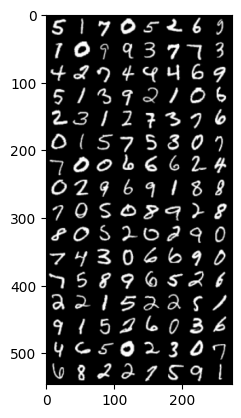

In [5]:
img, lbl = next(iter(train_dl))
outs = torchvision.utils.make_grid(img)

plt.imshow(outs.permute(1,2,0))
plt.show()

#`Generator`

In [6]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [7]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.convT1 = nn.ConvTranspose2d(100,80,2,2, bias=False)
    self.relu1 = nn.ReLU()


    self.convT2 = nn.ConvTranspose2d(80,60,2,2, bias=False)
    self.relu2 = nn.ReLU()

    self.convT3 = nn.ConvTranspose2d(60,40,2,2, bias=False)
    self.relu3 = nn.ReLU()


    self.convT4 = nn.ConvTranspose2d(40,20,2,2, bias=False)
    self.relu4 = nn.ReLU()


    self.convT5 = nn.ConvTranspose2d(20,1,2,2, bias=False)


  def forward(self, x):

    f1 = self.relu1(self.convT1(x))

    f2 = self.relu2(self.convT2(f1))

    f3 = self.relu3(self.convT3(f2))

    f4 = self.relu4(self.convT4(f3))

    f5 = self.convT5(f4)

    return f5

In [11]:
generator = Generator().to(device)
x = torch.rand(size = (16,100,1,1)).to(device)
y = generator(x)
print(y.shape)

torch.Size([16, 1, 32, 32])


#`Discriminator`

In [12]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.conv_stack_1 = nn.Sequential(
        nn.Conv2d(1,16,3,1, bias = False),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.conv_stack_2 = nn.Sequential(
        nn.Conv2d(16,32,3,1, bias = False),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.conv = nn.Conv2d(32,64,3,1)


  def forward(self, x):

    f1 = self.conv_stack_1(x)
    f2 = self.conv_stack_2(f1)
    f3 = self.conv(f2)

    return f3

In [13]:
discriminator = Discriminator().to(device)
x = torch.rand(size = (16,1,32,32)).to(device)
y = discriminator(x)
print(y.shape)

torch.Size([16, 64, 4, 4])


#`MMD`

In [15]:
def mmd(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    if kernel == "multiscale":

        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1

    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)



    return torch.mean(XX + YY - 2. * XY)

In [17]:

x1 = torch.rand(size = (16,1,32,32)).view(-1,32*32).to(device)
x2 = torch.rand(size = (16,1,32,32)).view(-1,32*32).to(device)
# print(x1.T.shape)
y= mmd(x1,x2,"rbf")
print(y)

tensor(0.4755, device='cuda:0')


In [18]:
opt_G = torch.optim.Adam(params =generator.parameters(), lr = 1e-3)
opt_D = torch.optim.Adam(params = discriminator.parameters(), lr = 1e-3)

#`Train`

In [19]:
x = torch.tensor([1,2,-3])
y = torch.clamp(x,max = 0)
y

tensor([ 0,  0, -3])

In [22]:
def train(data, generator, discriminator, opt_G, opt_D):
  generator.train()
  discriminator.train()


  size = len(data.dataset)

  for b,(x,_) in enumerate(data):
    x = x.to(device)

    b,c,w,h = x.shape

    z = torch.randn(size = (b,100,1,1)).to(device)

    #stepA

    opt_G.zero_grad()
    opt_D.zero_grad()

    generated_image_A = generator(z)
    loss_mmd_A = mmd(x.view(-1,32*32),generated_image_A.view(-1,32*32),"rbf")
    loss_2_A = torch.clamp(discriminator(x).mean() - discriminator(generator(z)).mean(),max = 0)
    # print(loss_2_A)
    lossA = loss_mmd_A + loss_2_A

    lossA.backward()

    opt_D.step()

    #stepB

    opt_G.zero_grad()
    opt_D.zero_grad()

    generated_image_B = generator(z)
    lossB = mmd(x.view(-1,32*32), generated_image_B.view(-1,32*32),"rbf")
    lossB.backward()

    opt_G.step()


    if b % 200 == 0:
      print(f"[{b*len(x)} | {size}]  lossA:{lossA.item()}  lossB:{lossB.item()}")





In [32]:
for e in range(50):
  print(f"epoch:{e+1}=-=-=-=-")
  train(train_dl, generator, discriminator, opt_G, opt_D)

epoch:1=-=-=-=-
epoch:2=-=-=-=-
epoch:3=-=-=-=-
epoch:4=-=-=-=-
epoch:5=-=-=-=-
epoch:6=-=-=-=-
epoch:7=-=-=-=-
epoch:8=-=-=-=-
epoch:9=-=-=-=-
epoch:10=-=-=-=-
epoch:11=-=-=-=-
epoch:12=-=-=-=-
epoch:13=-=-=-=-
epoch:14=-=-=-=-
epoch:15=-=-=-=-
epoch:16=-=-=-=-
epoch:17=-=-=-=-
epoch:18=-=-=-=-
epoch:19=-=-=-=-
epoch:20=-=-=-=-
epoch:21=-=-=-=-
epoch:22=-=-=-=-
epoch:23=-=-=-=-
epoch:24=-=-=-=-
epoch:25=-=-=-=-
epoch:26=-=-=-=-
epoch:27=-=-=-=-
epoch:28=-=-=-=-
epoch:29=-=-=-=-
epoch:30=-=-=-=-
epoch:31=-=-=-=-
epoch:32=-=-=-=-
epoch:33=-=-=-=-
epoch:34=-=-=-=-
epoch:35=-=-=-=-
epoch:36=-=-=-=-
epoch:37=-=-=-=-
epoch:38=-=-=-=-
epoch:39=-=-=-=-
epoch:40=-=-=-=-
epoch:41=-=-=-=-
epoch:42=-=-=-=-
epoch:43=-=-=-=-
epoch:44=-=-=-=-
epoch:45=-=-=-=-
epoch:46=-=-=-=-
epoch:47=-=-=-=-
epoch:48=-=-=-=-
epoch:49=-=-=-=-
epoch:50=-=-=-=-


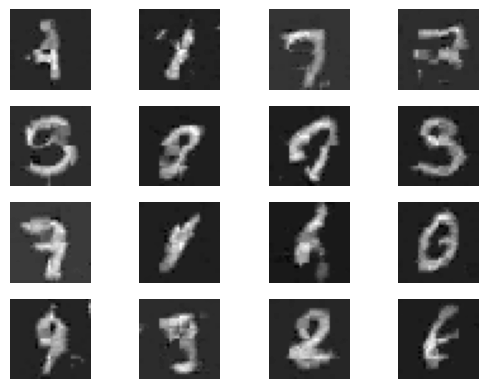

In [33]:
z = torch.randn(size = (16,100,1,1)).to(device)

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(generator(z)[i].cpu().detach().numpy().reshape(32,32,1), cmap = "gray")
  plt.axis("off")

plt.show()